<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Импорт-библиотек" data-toc-modified-id="Импорт-библиотек-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Импорт библиотек</a></span></li><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Метрика.-Описание" data-toc-modified-id="Метрика.-Описание-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Метрика. Описание</a></span></li><li><span><a href="#Распознавание-таблиц" data-toc-modified-id="Распознавание-таблиц-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Распознавание таблиц</a></span><ul class="toc-item"><li><span><a href="#Модель-NANONETSOCR" data-toc-modified-id="Модель-NANONETSOCR-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Модель NANONETSOCR</a></span><ul class="toc-item"><li><span><a href="#Установка-модели.-Пример-работы" data-toc-modified-id="Установка-модели.-Пример-работы-5.1.1"><span class="toc-item-num">5.1.1&nbsp;&nbsp;</span>Установка модели. Пример работы</a></span></li><li><span><a href="#Преобразование-распознанных-данных" data-toc-modified-id="Преобразование-распознанных-данных-5.1.2"><span class="toc-item-num">5.1.2&nbsp;&nbsp;</span>Преобразование распознанных данных</a></span></li><li><span><a href="#Тестирование-на-всех-данных" data-toc-modified-id="Тестирование-на-всех-данных-5.1.3"><span class="toc-item-num">5.1.3&nbsp;&nbsp;</span>Тестирование на всех данных</a></span></li></ul></li></ul></li><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></div>

# Распознавание таблиц с медицинских справок для DonorSearch

**Цель:** автоматизировать перенос данных с фотографий медицинских справок донора в формат .csv.

**Задача:** детектировать табличную часть справки, распознать текст и привести данные к требуемому шаблону

## Импорт библиотек

In [1]:
#!pip install opencv-python -q  

In [2]:
import pandas as pd
import cv2
import os
import re
from re import search
import time
from os import listdir
from datetime import datetime 

from PIL import Image as PImage

import numpy as np
import matplotlib.pyplot as plt

## Обзор данных

In [3]:
t=pd.read_csv('data/405/target/141899.csv')
t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ID                       29 non-null     int64 
 1   ID пользователя          29 non-null     int64 
 2   Класс крови              29 non-null     object
 3   Дата донации             29 non-null     object
 4   Дата добавления донации  29 non-null     object
 5   Тип донации              29 non-null     object
 6   Регион                   29 non-null     object
 7   Место стадчи             29 non-null     int64 
 8   Статус донации           29 non-null     object
 9   Есть справка             29 non-null     object
dtypes: int64(3), object(7)
memory usage: 2.4+ KB


In [4]:
t=pd.read_csv('data/405/target/204119.csv')
t.head(14)

ID  ID пользователя    Класс крови Дата донации  \
0  170415           204119  Цельная кровь   01.04.2015   
1  170430           204119  Цельная кровь   27.07.2017   
2  170431           204119  Цельная кровь   11.10.2017   
3  170432           204119  Цельная кровь   30.07.2018   
4  170433           204119  Цельная кровь   16.10.2018   
5  170434           204119  Цельная кровь   15.10.2019   

  Дата добавления донации   Тип донации                             Регион  \
0              23.12.2022  Безвозмездно     Россия, Тульская область, Тула   
1              23.12.2022  Безвозмездно  Россия, Тульская область, Кимовск   
2              23.12.2022  Безвозмездно  Россия, Тульская область, Кимовск   
3              23.12.2022  Безвозмездно  Россия, Тульская область, Кимовск   
4              23.12.2022  Безвозмездно  Россия, Тульская область, Кимовск   
5              23.12.2022  Безвозмездно  Россия, Тульская область, Кимовск   

     Место стадчи Статус донации Есть справка  
0             556        Принята           Да  
1  Выездная акция        Принята           Да  
2  Выездная акция        Принята           Да  
3  Выездная акция        Принята           Да  
4  Выездная акция        Принята           Да  
5  Выездная акция        Принята           Да

In [5]:
img = PImage.open('C:/Users/zoika/OneDrive/Рабочий стол/YP ds54/Practika/OCR_Donor_search/data/405/scan/141899 .jpg')
#img

Мы видим, что нам необходимо заполнить с картинки не все колонки, а только 'Класс крови','Дата донации','Тип донации'. Пропусков не обнаружено. Даты не в формате дат. Также, есть несоответствие в названиях и то, что значение одной колонки на картинке, в целевой табличке разбито на две:


In [6]:
df_info = { 'Дано на фото:  Вид дон-ва': ['кр / д ( бв )', 'пл / д ( бв ), пп / д ( бв ), п / ф ( бв )', 'т / ф ( бв ), ц / д ( бв )'],
          'Должны получить в csv: Класс крови': ['Цельная кровь', 'Плазма', 'Тромбоциты'],
           'Тип донации': ['Безвозмездно', 'Безвозмездно', 'Безвозмездно'] }
df_info = pd.DataFrame(df_info)
df_info

Дано на фото:  Вид дон-ва  \
0                               кр / д ( бв )   
1  пл / д ( бв ), пп / д ( бв ), п / ф ( бв )   
2                  т / ф ( бв ), ц / д ( бв )   

  Должны получить в csv: Класс крови   Тип донации  
0                      Цельная кровь  Безвозмездно  
1                             Плазма  Безвозмездно  
2                         Тромбоциты  Безвозмездно

Выявлены возможные сокращения:

**Класс крови:**
- Цельная кровь = [кр / д]
- Плазма = [пл / д, пп / д, п / ф]
- Тромбоциты = [т / ф, ц / д]


**Тип донации:**
-  Безвозмездно = [( бв )]


Учтем это в дальнейшей работе

## Загрузка данных 

Чтобы было удобно прогонять сразу все данные через модель и оценивать качество распознавания - объединим все картинки и соответствующие им таргеты (файлы .csv) в одном датафрейме.

Для этого напишем функцию, которая принимает на вход путь с расположением картинок и путь с расположением целевых таблиц. 
На выходе будет датафрейм, сопоставляющий для каждой картинки: имя объекта, путь для каждой картинки (необходимо для библиотки нанонетс),саму картинку, и соответствующий ей таргет (файл csv). 

Внутри функции, из csv-файлов будут удалены лишние столбцы, которые нет необходимости заполнять на основании картинки.

In [7]:
path='data/405/scan/'  #у меня картинки в отдельной папке scan, ноут в одной папке с data...
path_csv='data/405/target/'

def loadImages(path,path_csv):

    imagesList = listdir(path)
    loadedImages = []
    for image in imagesList:
       
        img = PImage.open(path + image)
        path_jpg=path + image
        #img=np.array(img)/255
        
        name=str(image)
        name=name.split(' ')[0]
        name=re.sub(r'(.jpg)', '', name)
        
        target=pd.read_csv(path_csv + name + '.csv')
        target=target[['Класс крови','Дата донации','Тип донации']] #,'Регион','Место стадчи'
        target['Дата донации']=pd.to_datetime(target['Дата донации'], format='%d.%m.%Y',errors='coerce')
        
        
        list=[name,img,path_jpg,target]
        loadedImages.append(list)   
        
        df=pd.DataFrame(loadedImages, columns = ['name','input_image','path_jpg','target_csv'])
        df=df.set_index('name')

    return df

df = loadImages(path,path_csv)
df.head(3)

input_image  \
name                                                        
141899  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
204119  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
213950  <PIL.JpegImagePlugin.JpegImageFile image mode=...   

                         path_jpg  \
name                                
141899  data/405/scan/141899 .jpg   
204119  data/405/scan/204119 .jpg   
213950   data/405/scan/213950.jpg   

                                               target_csv  
name                                                       
141899        Класс крови Дата донации   Тип донации
0...  
204119       Класс крови Дата донации   Тип донации
0 ...  
213950        Класс крови Дата донации   Тип донации
0...

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15 entries, 141899 to 256838
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   input_image  15 non-null     object
 1   path_jpg     15 non-null     object
 2   target_csv   15 non-null     object
dtypes: object(3)
memory usage: 480.0+ bytes


In [9]:
df['target_csv']['204119'].info()  #обращение к целевой таблице

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Класс крови   6 non-null      object        
 1   Дата донации  6 non-null      datetime64[ns]
 2   Тип донации   6 non-null      object        
dtypes: datetime64[ns](1), object(2)
memory usage: 272.0+ bytes


На данном этапе мы загрузили и сопоставили все, имеющиеся данные. Проверили, что все 15 изображений на месте. Пропусков, нулей - нет.

## Метрика. Описание
Чтобы можно было оценивать и сравнивать различные модели или их модификации - нужна метрика.
Поэтому напишем функцию, которая будет считать аналог accuracy для таблиц. А именно, считать и выводить - долю, правильно распознанных ячеек.

In [10]:
def metric_acc(df_pred,df_target):
    
    count=0
    count_good=0
    
    for j in range(df_target.shape[1]):
        for i in range(df_target.shape[0]):
            try:
                if df_target.iloc[i,j]==df_pred.iloc[i,j]:
                    count_good+=1
                    count+=1
                else: count+=1
            except:count+=1
    print('Всего ячеек:',count,'. Верных:',count_good, '. Acc:',count_good/count)
    
    return count_good/count

## Распознавание таблиц

**Гипотеза №1:** с помощью библиотеки NANONETSOCR удастся распознать не менее 70% табличных данных (колонки: 'Класс крови','Дата донации','Тип донации')

###  Модель NANONETSOCR
Данная модель способна сразу выделить на изображении таблицу и распознать.

Загрузка библиотек и самой модели:

####  Установка модели. Пример работы

In [11]:
#!pip install ocr-nanonets-wrapper -q

In [12]:
from nanonets import NANONETSOCR
model = NANONETSOCR()
model.set_token('KEY-KEY-KEY') #ключ генерируется в личном кабинете на сайте https://nanonets.com

Проверим работу модели на примере произвольной картинки.
Картинка:

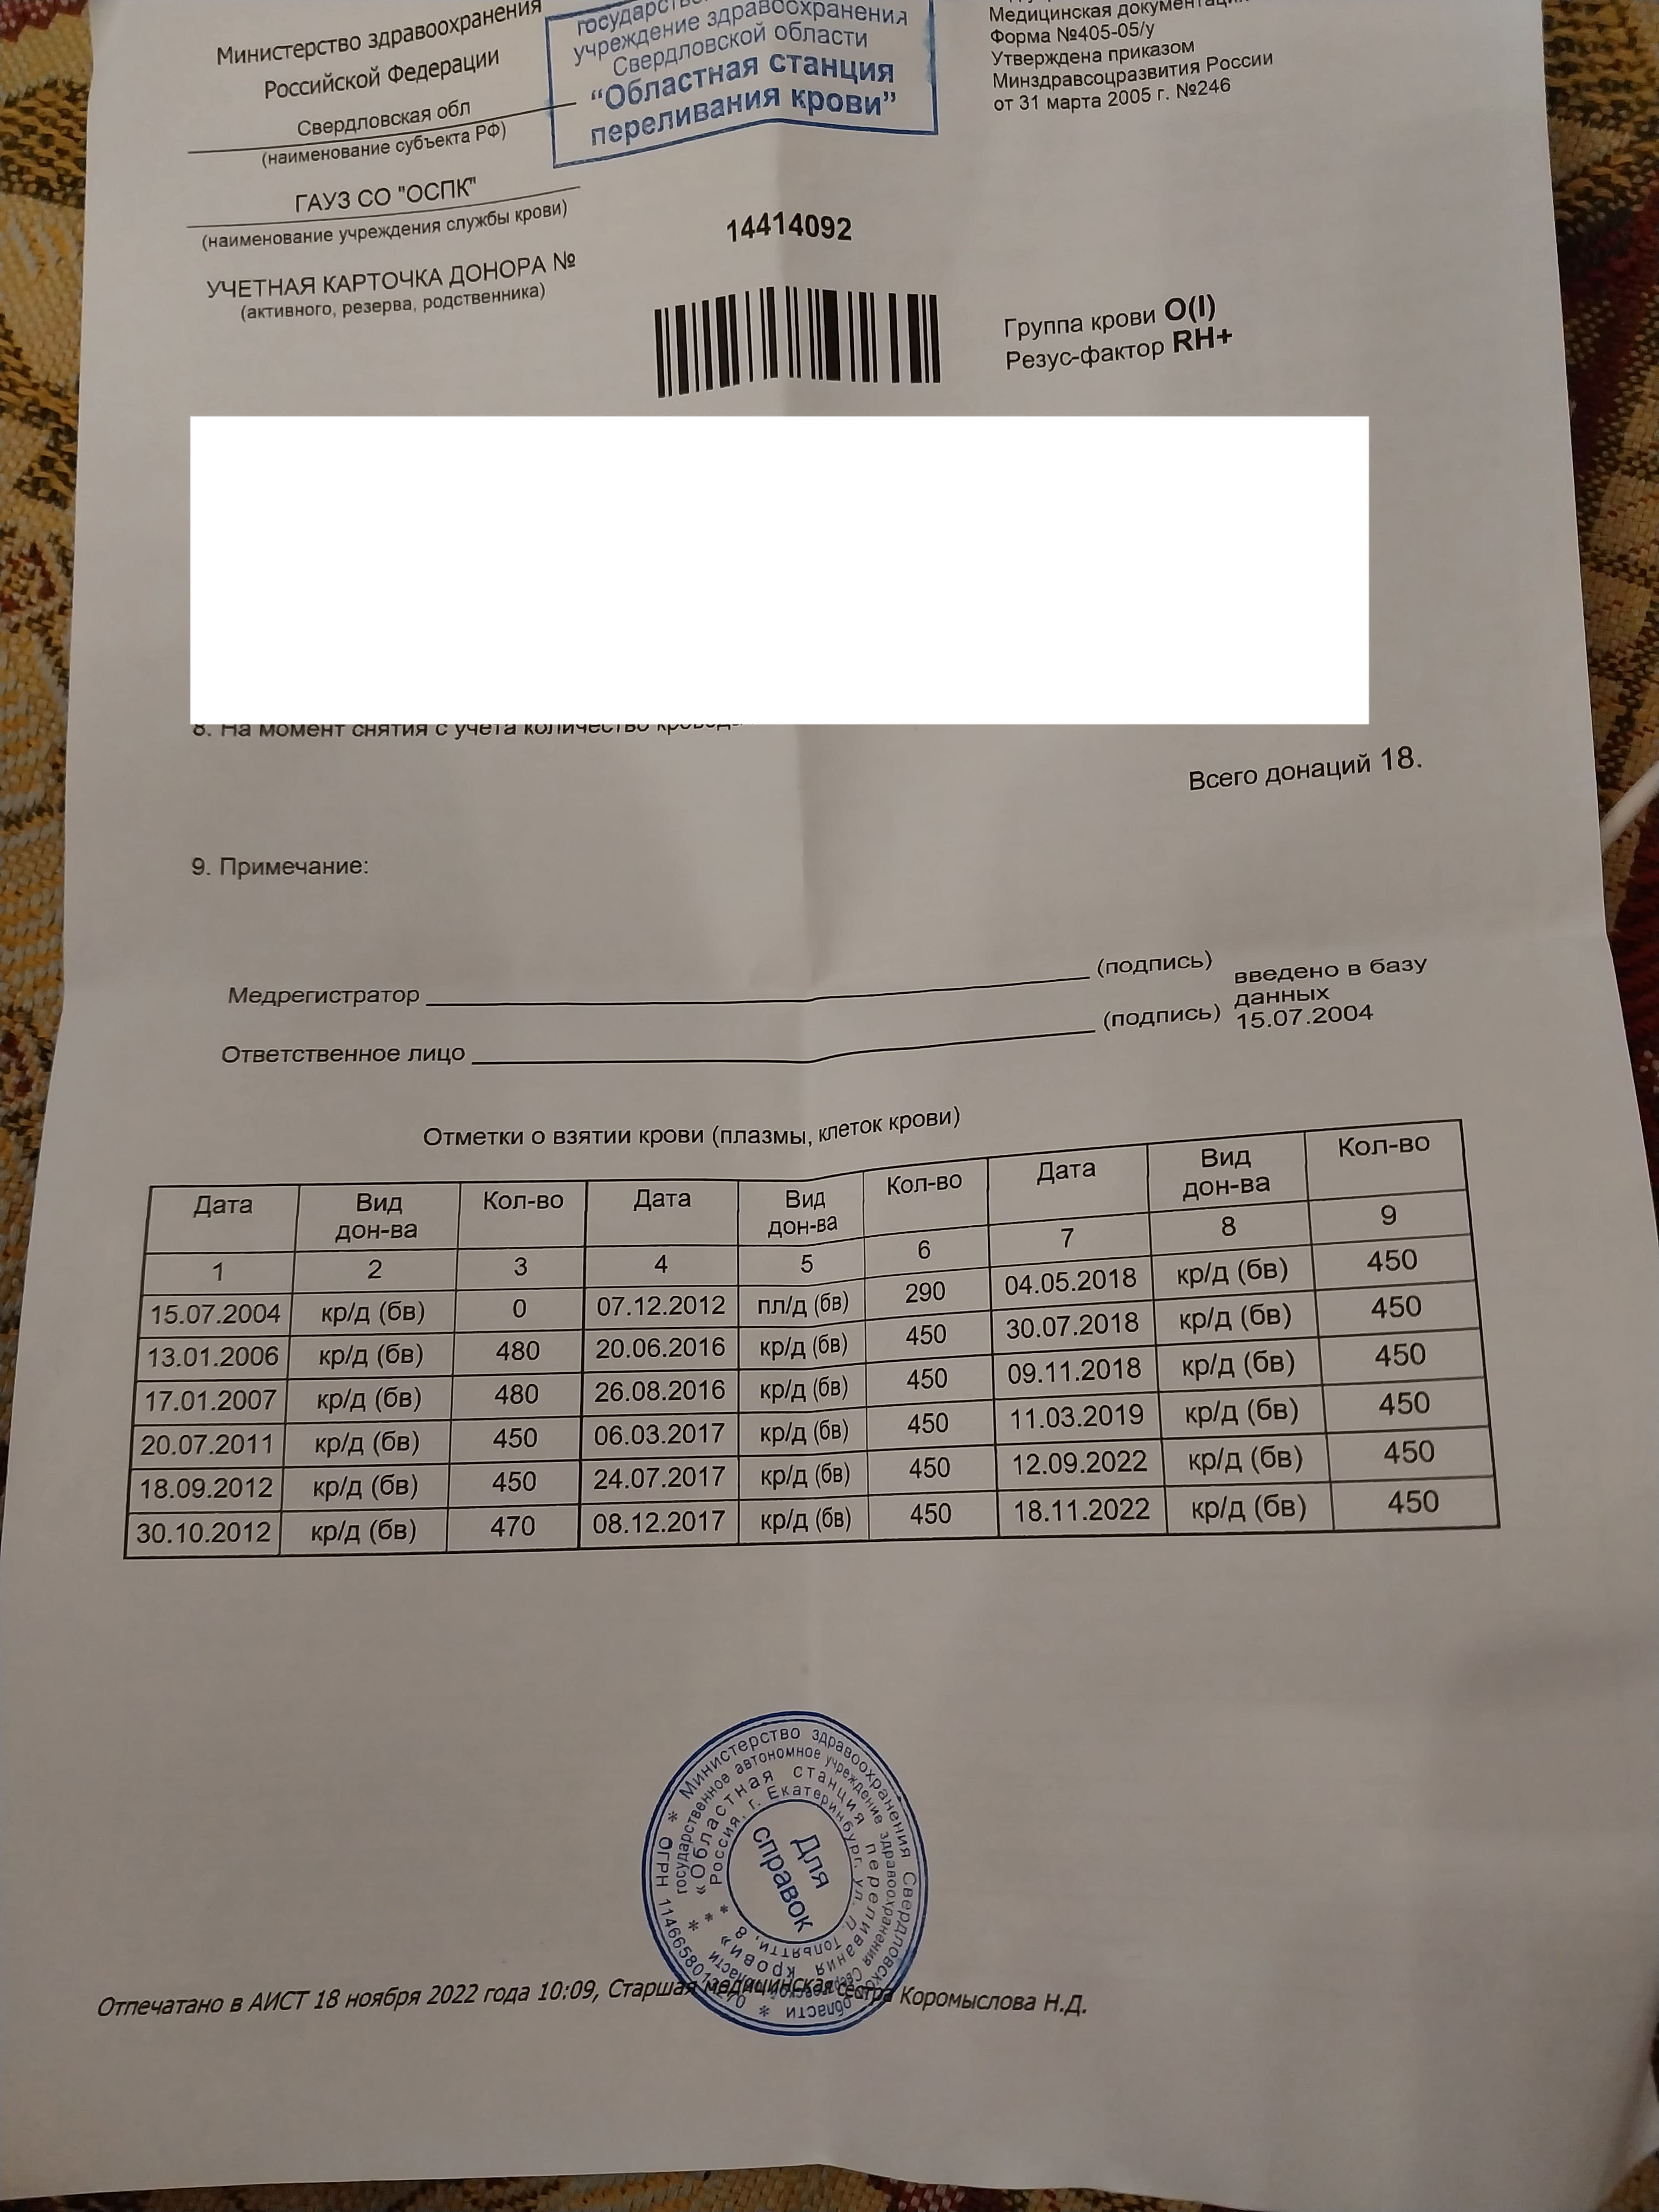

In [13]:
num_img_test='225629' #выберем произвольный номер картинки (строки в дф) 
df['input_image'][num_img_test]

Используем метод convert_to_csv для данной картинки и выведем результат:

In [14]:
%%time
model.convert_to_csv(df['path_jpg'][num_img_test],output_file_name='OUTPUTFILE.csv')
test_NANO=pd.read_csv('OUTPUTFILE.csv')
test_NANO

CPU times: total: 31.2 ms
Wall time: 23.9 s


Unnamed: 0     Unnamed: 1 Unnamed: 2    Unnamed: 3     Unnamed: 4  \
0     TABLE 1            NaN        NaN           NaN            NaN   
1         NaN            NaN        NaN           NaN            NaN   
2        Дата  Вид\nдон - ва   Кол - во          Дата  Вид\nдон - ва   
3           1              2          3             4              5   
4  15.07.2004  кр / д ( бв )          0    07.12.2012  Пл / д ( бв )   
5  13.01.2006  кр / д ( бв )        480  20.06.2016 |  кр / д ( бв )   
6  17.01.2007  кр / д ( бв )        480    26.08.2016  Кр / д ( бв )   
7  20.07.2011  кр / д ( бв )        450  06.03.2017 |  кр / д ( бв )   
8  18.09.2012  кр / д ( бв )        450  24.07.2017 |  кр / д ( бв )   
9  30.10.2012  кр / д ( бв )        470  08.12.2017 |  кр / д ( бв )   

  Unnamed: 5  Unnamed: 6        Unnamed: 7   Unnamed: 8  
0        NaN         NaN               NaN          NaN  
1        NaN         NaN               NaN          NaN  
2   Кол - во        Дата  Вид\nдон - ва\n8  Кол - во\n9  
3          6           7               NaN          450  
4        290  04.05.2018     кр / д ( бв )          450  
5        450  30.07.2018     кр / д ( бв )          NaN  
6        450  09.11.2018     кр / д ( бв )          450  
7        450  11.03.2019     кр / д ( бв )          450  
8        450  12.09.2022     кр / д ( бв )          450  
9        450  18.11.2022     кр / д ( бв )          450

Даже на примере размытой картинки мы видим, что модель смогла выделить таблицу и верно оперделить больше половины числовых значений. 

Однако, много лишней информации и последовательность колонок отличается от целевой. Чтобы это исправить и привести данные как можно ближе к требованиям заказчика, напишем специальную функцию в следующем пункте.

####  Преобразование распознанных данных

In [15]:
def df_transform(df):

 # Чистка таблицы ---------------------------------------------------------   

    df = df.applymap(lambda cell: cell.lower() if isinstance(cell, str) else cell)
    df = df.applymap(lambda cell: cell.replace(' ', '') if isinstance(cell, str) else cell)
    df = df.applymap(lambda cell: cell.replace('|', '') if isinstance(cell, str) else cell)

# Создадим новый дф перенесем в него данные в нужном порядке   --------------------------------------------------

    df_new=pd.DataFrame(columns=['Класс крови','Дата донации','Тип донации','Кол-во']) #,'Регион','Место стадчи'
    
    i_new=0
    
    for j in range(df.shape[1]):
        for i in range(df.shape[0]):
       
            if (df.iloc[i,j]=='дата') or (df.iloc[i,j]=='dara'):  # Доработать/  содержит д/d/ ата
                for i in range(i,df.shape[0]-2):
                    
                    stroka_df_new=[]
                    
               # Класс крови-------------------------------------
            
                    massiv  = '(?:{})'.format('|'.join(['k','ka','кр','к'])) #'Цельная кровь'
                    massiv1 = '(?:{})'.format('|'.join(['т / ф', 'ц / д','т/ф', 'ц/д','t / ф'])) #тромбоциты
                    massiv2 = '(?:{})'.format('|'.join(['пл/д', 'пл/ д','пл / д', 'пл /д','п / ф' \
                                                        ,'п/ф','п /ф','п/ ф','пп/д','пп / д'])) #Плазма
                    
                    if  search(massiv, str(df.iloc[i+2,j+1])):
                        stroka_df_new.append('Цельная кровь') 
                    elif search(massiv1, str(df.iloc[i+2,j+1])):
                        stroka_df_new.append('Тромбоциты')
                    elif search(massiv2, str(df.iloc[i+2,j+1])):
                        stroka_df_new.append('Плазма')                        
                    else:stroka_df_new.append('unknown') 
                    

              #  Дата донации-------------------------------------       
                    
                    try:
                        data_new=pd.to_datetime(df.iloc[i+2,j], format='%d.%m.%y').strftime('%d.%m.%Y') 
                        stroka_df_new.append(data_new)
                    except:

                        try:
                            data_new=pd.to_datetime(df.iloc[i+2,j], format='%d.%m.%Y').strftime('%d.%m.%Y') 
                            stroka_df_new.append(data_new)
                        except:
                            stroka_df_new.append('unknown')

            
            
            
             # Тип донации---------------------------------------- 
                  #  massiv_bv  = '(?:{})'.format('|'.join(['bB','бB','бв','бп','ба','68','бe','бе'])) #'Безвозмездно' 'Бв','БВ','бВ',
            
                    if search('плат',str(df.iloc[i+2,j+1])):
                        stroka_df_new.append('Платно')
                    

                    else:
                        stroka_df_new.append('Безвозмездно')
                      
             #---------------------------------------------------------      
                   
                   # stroka_df_new.append('unknown')           # 'Регион'
                   # stroka_df_new.append('unknown')           # 'Место стадчи'
                    stroka_df_new.append(df.iloc[i+2,j+2])    # Kol-vo

                    df_new.loc[i_new]=stroka_df_new
                    i_new+=1
            
    
    for i in range(df_new.shape[0]):
        if (df_new['Класс крови'][i]=='unknown') and (df_new['Дата донации'][i]=='unknown'):
            df_new=df_new.drop([i])
    try:     
        df_new['Дата донации']=pd.to_datetime(df_new['Дата донации'],format="%d.%m.%Y",errors='coerce')
        df_new=df_new.sort_values('Дата донации') 
       
    except:
        print('Не получилось отсортировать дату')
    
    return df_new

In [16]:
test_NANO

Unnamed: 0     Unnamed: 1 Unnamed: 2    Unnamed: 3     Unnamed: 4  \
0     TABLE 1            NaN        NaN           NaN            NaN   
1         NaN            NaN        NaN           NaN            NaN   
2        Дата  Вид\nдон - ва   Кол - во          Дата  Вид\nдон - ва   
3           1              2          3             4              5   
4  15.07.2004  кр / д ( бв )          0    07.12.2012  Пл / д ( бв )   
5  13.01.2006  кр / д ( бв )        480  20.06.2016 |  кр / д ( бв )   
6  17.01.2007  кр / д ( бв )        480    26.08.2016  Кр / д ( бв )   
7  20.07.2011  кр / д ( бв )        450  06.03.2017 |  кр / д ( бв )   
8  18.09.2012  кр / д ( бв )        450  24.07.2017 |  кр / д ( бв )   
9  30.10.2012  кр / д ( бв )        470  08.12.2017 |  кр / д ( бв )   

  Unnamed: 5  Unnamed: 6        Unnamed: 7   Unnamed: 8  
0        NaN         NaN               NaN          NaN  
1        NaN         NaN               NaN          NaN  
2   Кол - во        Дата  Вид\nдон - ва\n8  Кол - во\n9  
3          6           7               NaN          450  
4        290  04.05.2018     кр / д ( бв )          450  
5        450  30.07.2018     кр / д ( бв )          NaN  
6        450  09.11.2018     кр / д ( бв )          450  
7        450  11.03.2019     кр / д ( бв )          450  
8        450  12.09.2022     кр / д ( бв )          450  
9        450  18.11.2022     кр / д ( бв )          450

In [17]:
df_test=df_transform(test_NANO)
df_test

Класс крови Дата донации   Тип донации Кол-во
0   Цельная кровь   2004-07-15  Безвозмездно      0
1   Цельная кровь   2006-01-13  Безвозмездно    480
2   Цельная кровь   2007-01-17  Безвозмездно    480
3   Цельная кровь   2011-07-20  Безвозмездно    450
4   Цельная кровь   2012-09-18  Безвозмездно    450
5   Цельная кровь   2012-10-30  Безвозмездно    470
6          Плазма   2012-12-07  Безвозмездно    290
7   Цельная кровь   2016-06-20  Безвозмездно    450
8   Цельная кровь   2016-08-26  Безвозмездно    450
9   Цельная кровь   2017-03-06  Безвозмездно    450
10  Цельная кровь   2017-07-24  Безвозмездно    450
11  Цельная кровь   2017-12-08  Безвозмездно    450
12  Цельная кровь   2018-05-04  Безвозмездно    450
13  Цельная кровь   2018-07-30  Безвозмездно    NaN
14  Цельная кровь   2018-11-09  Безвозмездно    450
15  Цельная кровь   2019-03-11  Безвозмездно    450
16  Цельная кровь   2022-09-12  Безвозмездно    450
17  Цельная кровь   2022-11-18  Безвозмездно    450

In [18]:
df_test['Дата донации']=pd.to_datetime(df_test['Дата донации'],format="%d.%m.%Y",errors='coerce')#.strftime('%d.%m.%Y')

In [19]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18 entries, 0 to 17
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Класс крови   18 non-null     object        
 1   Дата донации  18 non-null     datetime64[ns]
 2   Тип донации   18 non-null     object        
 3   Кол-во        17 non-null     object        
dtypes: datetime64[ns](1), object(3)
memory usage: 720.0+ bytes


In [20]:
df_test

Класс крови Дата донации   Тип донации Кол-во
0   Цельная кровь   2004-07-15  Безвозмездно      0
1   Цельная кровь   2006-01-13  Безвозмездно    480
2   Цельная кровь   2007-01-17  Безвозмездно    480
3   Цельная кровь   2011-07-20  Безвозмездно    450
4   Цельная кровь   2012-09-18  Безвозмездно    450
5   Цельная кровь   2012-10-30  Безвозмездно    470
6          Плазма   2012-12-07  Безвозмездно    290
7   Цельная кровь   2016-06-20  Безвозмездно    450
8   Цельная кровь   2016-08-26  Безвозмездно    450
9   Цельная кровь   2017-03-06  Безвозмездно    450
10  Цельная кровь   2017-07-24  Безвозмездно    450
11  Цельная кровь   2017-12-08  Безвозмездно    450
12  Цельная кровь   2018-05-04  Безвозмездно    450
13  Цельная кровь   2018-07-30  Безвозмездно    NaN
14  Цельная кровь   2018-11-09  Безвозмездно    450
15  Цельная кровь   2019-03-11  Безвозмездно    450
16  Цельная кровь   2022-09-12  Безвозмездно    450
17  Цельная кровь   2022-11-18  Безвозмездно    450

Проверка метрики:

In [21]:
metric_acc(df_test,df['target_csv'][num_img_test])

Всего ячеек: 54 . Верных: 53 . Acc: 0.9814814814814815


0.9814814814814815

In [22]:
df['target_csv'][num_img_test]

Класс крови Дата донации   Тип донации
0   Цельная кровь   2004-07-15  Безвозмездно
1   Цельная кровь   2006-01-13  Безвозмездно
2   Цельная кровь   2007-01-17  Безвозмездно
3   Цельная кровь   2011-07-20  Безвозмездно
4   Цельная кровь   2012-09-18  Безвозмездно
5   Цельная кровь   2012-10-30  Безвозмездно
6          Плазма   2012-12-17  Безвозмездно
7   Цельная кровь   2016-06-20  Безвозмездно
8   Цельная кровь   2016-08-26  Безвозмездно
9   Цельная кровь   2017-03-06  Безвозмездно
10  Цельная кровь   2017-07-24  Безвозмездно
11  Цельная кровь   2017-12-08  Безвозмездно
12  Цельная кровь   2018-05-04  Безвозмездно
13  Цельная кровь   2018-07-30  Безвозмездно
14  Цельная кровь   2018-11-09  Безвозмездно
15  Цельная кровь   2019-03-11  Безвозмездно
16  Цельная кровь   2022-09-12  Безвозмездно
17  Цельная кровь   2022-11-18  Безвозмездно

####  Тестирование на всех данных

In [23]:
%%time
def acc_all_nano(df):
    acc_list=[]
    for i, row in df.iterrows():
        print('file_name:',i)
        model.convert_to_csv(row['path_jpg'],output_file_name='OUTPUTFILE_for_metric.csv')
        nano_table=pd.read_csv('OUTPUTFILE_for_metric.csv')
        new_nano_table=df_transform(nano_table)
        acc=metric_acc(new_nano_table,row['target_csv'])
        acc_list.append(acc) 
    print('Метрика, усредненная:',sum(acc_list)/len(acc_list))
    return sum(acc_list)/len(acc_list)

acc_all_nano(df)

file_name: 141899
Всего ячеек: 87 . Верных: 35 . Acc: 0.40229885057471265
file_name: 204119
Всего ячеек: 18 . Верных: 18 . Acc: 1.0
file_name: 213950
Всего ячеек: 66 . Верных: 66 . Acc: 1.0
file_name: 225629
Всего ячеек: 54 . Верных: 53 . Acc: 0.9814814814814815
file_name: 227414
Всего ячеек: 60 . Верных: 52 . Acc: 0.8666666666666667
file_name: 228963
Всего ячеек: 69 . Верных: 24 . Acc: 0.34782608695652173
file_name: 231820
Всего ячеек: 39 . Верных: 39 . Acc: 1.0
file_name: 233749
Всего ячеек: 63 . Верных: 63 . Acc: 1.0
file_name: 236000
Всего ячеек: 15 . Верных: 15 . Acc: 1.0
file_name: 238716
Всего ячеек: 108 . Верных: 108 . Acc: 1.0
file_name: 243478
Всего ячеек: 114 . Верных: 47 . Acc: 0.41228070175438597
file_name: 245365
Всего ячеек: 111 . Верных: 111 . Acc: 1.0
file_name: 254586
Всего ячеек: 33 . Верных: 31 . Acc: 0.9393939393939394
file_name: 256578
Всего ячеек: 30 . Верных: 0 . Acc: 0.0
file_name: 256838
Всего ячеек: 66 . Верных: 24 . Acc: 0.36363636363636365
Метрика, усреднен

0.7542389393642713

## Вывод:
В данном проекте:
- Проведено исследование модели NANONETSOCR
- Разработана функция постобработки распознанных данных
- Проведена оценка работоспособности полученного алгоритма

С помощью доработоной модели удалось получить более 72% точности распознавания и заполнения колонок
- 'Класс крови',
- 'Дата донации',
- 'Тип донации', 

которые заказчик обозначил, как самые важные и трудозатратные. Таким образом, гипотеза №1 - подтвердилась.

Время полного цикла преобразований одного изображения занимает от 10 до 30 секунд.

Также наша модель хорошо распознает колонку "Количество", однако, ее нет в целевых таблицах, поэтому в расчет метрики ее не включили, но, если заказчику понадобится в будущем, эта клонка, то ее легко можно добавить.